In [1]:
!ls

DeepSet Max.ipynb DeepSet Sum.ipynb data


In [2]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [3]:
188*0.8

150.4

In [4]:
#torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


In [5]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2532], x=[1144, 7], edge_attr=[2532, 4], y=[64], batch=[1144], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2436], x=[1111, 7], edge_attr=[2436, 4], y=[64], batch=[1111], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 904], x=[409, 7], edge_attr=[904, 4], y=[22], batch=[409], ptr=[23])



In [6]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool,global_sort_pool,global_add_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)
        self.salidaConv = torch.zeros(0)
        self.salidaPooling = torch.zeros(0)
    def forward(self, x, edge_index, batch):
        
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        self.salidaConv = x
        #print("Primera shape",x.shape)
        # 2. Readout layer
        #print(x.shape)
        x = global_add_pool(x, batch)  # [batch_size, hidden_channels]
        self.salidaPooling = x
        #print(x)
        #x = GlobalPooling(x,batch)
        #x = x.sum(dim=0)
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.lin(x)
        #print(x.shape)
        return x

model = GCN(hidden_channels=18)
print(model)

GCN(
  (conv1): GCNConv(7, 18)
  (conv2): GCNConv(18, 18)
  (conv3): GCNConv(18, 18)
  (lin): Linear(in_features=18, out_features=2, bias=True)
)


In [7]:
model = GCN(hidden_channels=18)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        #print("hola",out)
        #print(data.y)
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.
resultados = []
for i in range(10):
    dataset = dataset.shuffle()

    train_dataset = dataset[:150]
    test_dataset = dataset[150:]

    train_loader = DataLoader(train_dataset.shuffle(), batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset.shuffle(), batch_size=64, shuffle=False)
    model = GCN(hidden_channels=18)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, 50):
        train()
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        #print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    print(f'RUN:{i},Test Acc:{test_acc:.4f}')
    resultados.append(test_acc)

RUN:0,Test Acc:0.7368
RUN:1,Test Acc:0.6842
RUN:2,Test Acc:0.7895
RUN:3,Test Acc:0.7895
RUN:4,Test Acc:0.7895
RUN:5,Test Acc:0.7368
RUN:6,Test Acc:0.7632
RUN:7,Test Acc:0.5526
RUN:8,Test Acc:0.8158
RUN:9,Test Acc:0.7632


In [8]:
res= torch.Tensor(resultados)
print(torch.mean(res))
print(torch.std(res))


tensor(0.7421)
tensor(0.0763)


In [9]:
test_loader = DataLoader(test_dataset[2:], batch_size=1, shuffle=False)
sample = next(iter(test_loader))
sample.batch =torch.tensor(1)
print(sample)
print(sample.y)
out = model(sample.x,sample.edge_index, sample.batch)  # Perform a single forward pass.
pred = out.argmax(dim=1)  # Use the class with highest probability.
print(pred)
correct = 0
correct += int((pred[0] == sample[0].y).sum())  # Check against ground-truth labels.
print("Accuracy: ",(correct/1)*100)#Batch_size

DataBatch(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1], batch=1, ptr=[2])
tensor([1])
tensor([0, 1])
Accuracy:  0.0


In [10]:
#Nodos criticos
Conv_out= model.salidaConv
print(model.salidaConv.shape)
critical_nodes = Conv_out.argmax(0).unique().tolist()
Pool_out = model.salidaPooling
print(Conv_out.shape)
print(Pool_out.shape)
print(critical_nodes)
#print(Conv_out)

torch.Size([23, 18])
torch.Size([23, 18])
torch.Size([2, 18])
[4, 16, 18, 19, 20, 21]


DataBatch(edge_index=[2, 54], x=[23, 7], edge_attr=[54, 4], y=[1], batch=1, ptr=[2])
tensor([22, 21,  2, 11,  1,  5,  6, 18, 14,  9, 10,  0, 12,  3,  8, 15, 16, 17,
         7, 19, 20,  4, 13])


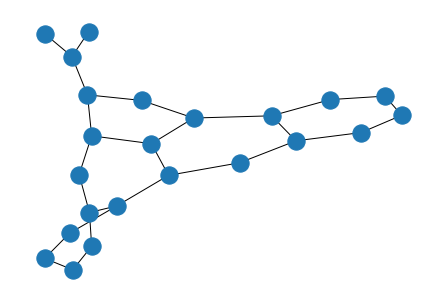

In [11]:
import networkx as nx
from torch_geometric.utils import *
#loader =  DataLoader(dataset, batch_size=1, shuffle=False)
grafo_init = sample
print(grafo_init)
A = to_networkx(grafo_init, to_undirected=True)
l=[]
for a in A.nodes:
    l.append(a)
ed= []
for e in A.edges:
    ed.append(e)
import igraph as ig
import chart_studio.plotly
Edges= ed
G=ig.Graph(Edges, directed=False)
labels= l
#groups = A.node_attr_dict_factory
N = len(A.nodes)
#print(N)
layt=G.layout('kk', dim=3)
#print(layt)
Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
Yn=[layt[k][1] for k in range(N)]# y-coordinates
Zn=[layt[k][2] for k in range(N)]# z-coordinates
Xe=[]
Ye=[]
Ze=[]
#print(Edges)
for e in Edges:
    Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ye+=[layt[e[0]][1],layt[e[1]][1], None]
    Ze+=[layt[e[0]][2],layt[e[1]][2], None]
nx.draw(A)

deg_centrality = list(nx.degree_centrality(A).values())
print(torch.Tensor(deg_centrality).argsort())
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(A.nodes()):
    #print(adjacencies,critical_nodes)
    if adjacencies in critical_nodes :
        node_adjacencies.append('rgb(256,0,0)')
    else:
        node_adjacencies.append('rgb(0,0,0)')
    #node_text.append('# of connections: '+str(len(adjacencies[1])))

In [12]:
from chart_studio import plotly
import plotly.graph_objs as go

trace1=go.Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=dict(color='rgb(125,125,125)', width=1),
               hoverinfo='none'
               )

trace2=go.Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=dict(symbol='circle',
                             size=6,
                             #color='#ff7f0e',
                             colorscale='Viridis',
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )
trace2.marker.color = node_adjacencies
#print(trace2)
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         title="3D graph visualization of Mutag dataset  by : Ahmed",
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
     margin=dict(
        t=100
    ),
    hovermode='closest',
    annotations=[
           dict(
           showarrow=False,
            text="Data source: <a href='https://plotly.com/python/v3/3d-network-graph/</a>",
            xref='paper',
            yref='paper',
            x=0,
            y=0.1,
            xanchor='left',
            yanchor='bottom',
            font=dict(
            size=14
            )
            )
        ],    )

In [13]:
import pandas as pd
import numpy as np
%matplotlib inline
import plotly.graph_objs as go
from  plotly.offline import plot
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected='true')
data=[trace1, trace2]
fig=go.Figure(data=data, layout=layout)

iplot(fig, filename='Les-Miserables')

In [14]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='PROTEINS')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: PROTEINS(1113):
Number of graphs: 1113
Number of features: 3
Number of classes: 2

Data(edge_index=[2, 162], x=[42, 3], y=[1])
Number of nodes: 42
Number of edges: 162
Average node degree: 3.86
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [15]:
#torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:890]
test_dataset = dataset[890:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 890
Number of test graphs: 223


In [16]:
1113*0.8

890.4000000000001

In [17]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool,global_sort_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)
        self.salidaConv = torch.zeros(0)
        self.salidaPooling = torch.zeros(0)
    def forward(self, x, edge_index, batch):
        
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        self.salidaConv = x
        #print("Primera shape",x.shape)
        # 2. Readout layer
        #print(x.shape)
        x = global_max_pool(x, batch)  # [batch_size, hidden_channels]
        self.salidaPooling = x
        #print(x)
        #x = GlobalPooling(x,batch)
        #x = x.sum(dim=0)
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.lin(x)
        #print(x.shape)
        return x

model = GCN(hidden_channels=18)
print(model)

GCN(
  (conv1): GCNConv(3, 18)
  (conv2): GCNConv(18, 18)
  (conv3): GCNConv(18, 18)
  (lin): Linear(in_features=18, out_features=2, bias=True)
)


In [24]:
model = GCN(hidden_channels=20)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        #print("hola",out)
        #print(data.y)
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.
resultados = []
for i in range(10):
    dataset = dataset.shuffle()

    train_dataset = dataset[:150]
    test_dataset = dataset[150:]

    train_loader = DataLoader(train_dataset.shuffle(), batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset.shuffle(), batch_size=64, shuffle=False)
    model = GCN(hidden_channels=18)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, 50):
        train()
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        #print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    print(f'RUN:{i},Test Acc:{test_acc:.4f}')
    resultados.append(test_acc)

RUN:0,Test Acc:0.7248
RUN:1,Test Acc:0.7373
RUN:2,Test Acc:0.7238
RUN:3,Test Acc:0.7269
RUN:4,Test Acc:0.7425
RUN:5,Test Acc:0.7310
RUN:6,Test Acc:0.7321
RUN:7,Test Acc:0.7290
RUN:8,Test Acc:0.7092
RUN:9,Test Acc:0.7321


In [19]:
res= torch.Tensor(resultados)
print(torch.mean(res))
print(torch.std(res))


tensor(0.7130)
tensor(0.0286)


In [20]:
test_loader = DataLoader(test_dataset[4:], batch_size=1, shuffle=False)
sample = next(iter(test_loader))
sample.batch =torch.tensor(1)
print(sample)
print(sample.y)
out = model(sample.x,sample.edge_index, sample.batch)  # Perform a single forward pass.
pred = out.argmax(dim=1)  # Use the class with highest probability.
print(pred)
correct = 0
correct += int((pred[0] == sample[0].y).sum())  # Check against ground-truth labels.
print("Accuracy: ",(correct/1)*100)#Batch_size

DataBatch(edge_index=[2, 62], x=[18, 3], y=[1], batch=1, ptr=[2])
tensor([0])
tensor([0, 0])
Accuracy:  100.0


DataBatch(edge_index=[2, 62], x=[18, 3], y=[1], batch=1, ptr=[2])
18
<Layout with 18 vertices and 3 dimensions>
[(0, 7), (0, 8), (0, 9), (1, 7), (1, 10), (1, 11), (2, 3), (2, 11), (2, 12), (3, 4), (3, 12), (3, 16), (4, 16), (4, 17), (5, 6), (5, 13), (5, 14), (5, 15), (6, 13), (6, 14), (7, 8), (7, 9), (7, 10), (8, 9), (10, 11), (11, 12), (12, 16), (13, 14), (14, 15), (14, 17), (15, 17)]


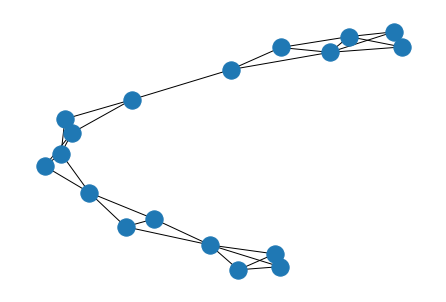

In [21]:
import networkx as nx
from torch_geometric.utils import *
#loader =  DataLoader(dataset, batch_size=1, shuffle=False)
grafo_init = sample
print(grafo_init)
A = to_networkx(grafo_init, to_undirected=True)
l=[]
for a in A.nodes:
    l.append(a)
ed= []
for e in A.edges:
    ed.append(e)
import igraph as ig
import chart_studio.plotly
Edges= ed
G=ig.Graph(Edges, directed=False)
labels= l
#groups = A.node_attr_dict_factory
N = len(A.nodes)
print(N)
layt=G.layout('kk', dim=3)
print(layt)
Xn=[layt[k][0] for k in range(N)]# x-coordinates of nodes
Yn=[layt[k][1] for k in range(N)]# y-coordinates
Zn=[layt[k][2] for k in range(N)]# z-coordinates
Xe=[]
Ye=[]
Ze=[]
print(Edges)
for e in Edges:
    Xe+=[layt[e[0]][0],layt[e[1]][0], None]# x-coordinates of edge ends
    Ye+=[layt[e[0]][1],layt[e[1]][1], None]
    Ze+=[layt[e[0]][2],layt[e[1]][2], None]
nx.draw(A)
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(A.nodes()):
    #print(adjacencies,critical_nodes)
    if adjacencies in critical_nodes :
        node_adjacencies.append('rgb(256,0,0)')
    else:
        node_adjacencies.append('rgb(0,0,0)')
    #node_text.append('# of connections: '+str(len(adjacencies[1])))

In [22]:
from chart_studio import plotly
import plotly.graph_objs as go

trace1=go.Scatter3d(x=Xe,
               y=Ye,
               z=Ze,
               mode='lines',
               line=dict(color='rgb(125,125,125)', width=1),
               hoverinfo='none'
               )

trace2=go.Scatter3d(x=Xn,
               y=Yn,
               z=Zn,
               mode='markers',
               name='actors',
               marker=dict(symbol='circle',
                             size=6,
                             #color='#ff7f0e',
                             colorscale='Viridis',
                             line=dict(color='rgb(50,50,50)', width=0.5)
                             ),
               text=labels,
               hoverinfo='text'
               )
trace2.marker.color = node_adjacencies
#print(trace2)
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )

layout = go.Layout(
         title="3D graph visualization of Mutag dataset  by : Ahmed",
         width=1000,
         height=1000,
         showlegend=False,
         scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
     margin=dict(
        t=100
    ),
    hovermode='closest',
    annotations=[
           dict(
           showarrow=False,
            text="Data source: <a href='https://plotly.com/python/v3/3d-network-graph/</a>",
            xref='paper',
            yref='paper',
            x=0,
            y=0.1,
            xanchor='left',
            yanchor='bottom',
            font=dict(
            size=14
            )
            )
        ],    )

In [23]:
import pandas as pd
import numpy as np
%matplotlib inline
import plotly.graph_objs as go
from  plotly.offline import plot
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode(connected='true')
data=[trace1, trace2]
fig=go.Figure(data=data, layout=layout)

iplot(fig, filename='Les-Miserables')